In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import json
from textblob import TextBlob
from scipy import stats
from sklearn import preprocessing
from geopy import distance
import time


# Constants

In [2]:
DEBUG = True
INDEX_COLUMN_NAME = None
RANDOM_STATE = 12
SOURCE_DIR = './'
# SOURCE_DIR = '../input/sf-booking/'
TARGET_COLUMN_NAME = 'reviewer_score'
TEST_SIZE = 0.25

# Helper functions

In [3]:
def figax(figsize=(7, 4), rowcol=None, axes=[0,0,1,1], name='Foo'):
    fig = plt.figure(name, figsize=figsize)
    
    if rowcol is None:
        ax = fig.add_axes(axes)
    else:
        rows, cols = rowcol
        ax = fig.subplots(rows, cols)

    return fig, ax

def describe_hist_box(data, column, log=False):
    global DEBUG

    if not DEBUG:
        return

    data=hotels[[column]]

    # print(data.describe())

    fig, ax = figax(rowcol=(2, 1), name=column)

    sns.histplot(ax=ax[0], data=data, binwidth=1)
    sns.boxplot(ax=ax[1], data=data, orient='h')

    if log:
        ax[0].set_xscale('log')
        ax[1].set_xscale('log')

def convert_rare_values_to_others(data=None, feature='', how_many_to_keep=15):
    value_counts = data[feature].value_counts()

    difference_times = value_counts[0] / value_counts[how_many_to_keep]

    if difference_times < 100:
        debug_print(f'!! convert_rare_values_to_others for "{feature}"')
        debug_print(f'value_counts: {len(value_counts)}')
        debug_print(f'value_counts[0]: {value_counts[0]}')
        debug_print(f'value_counts[{how_many_to_keep}]: {value_counts[how_many_to_keep]}')
        debug_print(f'difference is {difference_times} times')

    allowed_values = value_counts.index[0: how_many_to_keep]
    data[feature] = data[feature].apply(lambda x: x if x in allowed_values else '-- others --')

onehot_encoders = None

def apply_onehot(data=None, features=None):
    global onehot_encoders

    if onehot_encoders is None:
        onehot_encoders = dict()

    for feature in features:
        # print(f'"{feature}" unique values: {len(data[feature].unique())}')
        if len(data[feature].unique()) > 15:
            convert_rare_values_to_others(data, feature)
        
        if onehot_encoders.get(feature) is None:
            onehot_encoders[feature] = ce.OneHotEncoder()
            onehot_encoders[feature].fit(data[feature])

        encoded_feature = onehot_encoders[feature].transform(data[feature])
        data[encoded_feature.columns] = encoded_feature
        # data.drop(columns=[feature], inplace=True)
        pass

binary_encoders = None

def apply_binary(data=None, features=None, is_test=False):
    global binary_encoders

    if binary_encoders is None:
        binary_encoders = dict()

    for feature in features:
        # print(f'len(data[feature].unique()) = {len(data[feature].unique())}')
        if len(data[feature].unique()) > 127:
            convert_rare_values_to_others(data, feature, how_many_to_keep=127)

        if binary_encoders.get(feature) is None:
            binary_encoders[feature] = ce.BinaryEncoder()
            binary_encoders[feature].fit(data[feature])

        encoded_feature = binary_encoders[feature].transform(data[feature])
        data[encoded_feature.columns] = encoded_feature
        # data.drop(columns=[feature], inplace=True)
        pass

def debug_print(*args, **kwargs):
    global DEBUG

    if DEBUG:
        print(*args, **kwargs)


def logger(fn):
    def decorated(*args, **kwargs):
        debug_print(f'>>> fn. `{fn.__name__}` is running')
        ts = time.time()
        res = fn(*args, **kwargs)
        te = time.time()
        delta = round((te-ts) * 1000)
        sec_mls = 'mls'
        if delta > 1000:
            delta = round(delta / 1000, 1)
            sec_mls = 's'
        debug_print(f'<<< fn. `{fn.__name__}` finished, took {delta} {sec_mls}')
        return res
    return decorated

# Load data

In [4]:
hotels_test = pd.read_csv(SOURCE_DIR + 'hotels_test.csv.zip', sep=',')
hotels_train = pd.read_csv(SOURCE_DIR + 'hotels_train.csv.zip', sep=',')
submission = pd.read_csv(SOURCE_DIR + 'submission.csv.zip', sep=',')


In [5]:
hotels = hotels_train.copy()

hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


# Data cleaning

- remove duplicates
- remove anomalies
- handle missing data in cells (fix them or remove rows)
- remove useless features

In [6]:
@logger
def remove_duplicates(data, is_test_data):
    # might remove some rows
    # we don't want that for the test set
    if is_test_data:
        return

    if INDEX_COLUMN_NAME is None:
        return

    data.drop(columns=[INDEX_COLUMN_NAME], inplace=True)
    m = data.duplicated()
    
    if m.sum() == 0:
        return

    data.drop_duplicates(inplace=True)

@logger
def remove_anomalies(data, is_test_data):
    # might remove some rows
    # we don't want that for the test set
    if is_test_data:
        return

    describe_hist_box(data, 'additional_number_of_scoring')
    m = data['additional_number_of_scoring'] > 1500
    debug_print(f'additional_number_of_scoring: {m.sum()}')
    data.drop(index=data[m].index, inplace=True)

    describe_hist_box(data, 'average_score')
    m = data['average_score'] < 6
    debug_print(f'average_score: {m.sum()}')
    data.drop(index=data[m].index, inplace=True)

    describe_hist_box(data, 'review_total_negative_word_counts', log=True)
    m = data['review_total_negative_word_counts'] > 60
    debug_print(f'review_total_negative_word_counts: {m.sum()}')
    data.drop(index=data[m].index, inplace=True)

    describe_hist_box(data, 'total_number_of_reviews', log=True)
    m = data['total_number_of_reviews'] > 6500
    debug_print(f'total_number_of_reviews: {m.sum()}')
    data.drop(index=data[m].index, inplace=True)

    describe_hist_box(data, 'review_total_positive_word_counts', log=True)
    m = data['review_total_positive_word_counts'] > 2e2
    debug_print(f'review_total_positive_word_counts: {m.sum()}')
    data.drop(index=data[m].index, inplace=True)

    describe_hist_box(data, 'total_number_of_reviews_reviewer_has_given', log=True)
    m = data['total_number_of_reviews_reviewer_has_given'] > 100
    debug_print(f'total_number_of_reviews_reviewer_has_given: {m.sum()}')
    data.drop(index=data[m].index, inplace=True)

    if not is_test_data:
        describe_hist_box(data, 'reviewer_score')
        m = data['reviewer_score'] < 5
        debug_print(f'reviewer_score: {m.sum()}')
        data.drop(index=data[m].index, inplace=True)

@logger
def handle_missing_data_in_cells(data, is_test_data):
    # data are missing in columns `lat` and `lng`
    # we will deal that later
    pass

@logger
def remove_useless_features(data, is_test_data):
    # columns `hotel_name` and `review_date` do not look important
    data.drop(columns=['hotel_name', 'review_date'], inplace=True)

@logger
def run_cleaning(data=None, is_test_data=False):
    data_copy = data.copy()

    remove_duplicates(data_copy, is_test_data)
    remove_anomalies(data_copy, is_test_data)
    handle_missing_data_in_cells(data_copy, is_test_data)
    remove_useless_features(data_copy, is_test_data)

    rows_before = data.shape[0]
    rows_after = data_copy.shape[0]
    delta = rows_before - rows_after
    percent = round(delta / rows_before * 100.0, 1)
    debug_print(f'cleaning removed {delta} rows ({percent}%)')

    return data_copy.reset_index(drop=True)

# Feature creation

In [7]:
@logger
def replace_address_with_hotel_city(data):
    def get_city(addr):
        city_country = addr.split(' ')[-2:]
        if ' '.join(city_country) == 'United Kingdom':
            return 'London'
        return city_country[0]        

    data['hotel_city'] = data['hotel_address'].apply(get_city)
    # data.drop(columns=['hotel_address'], inplace=True)
    pass

@logger
def replace_review_with_review_polarity(data):
    def calc_polarity(text):
        return TextBlob(text).sentiment.polarity

    data['negative_review_polarity'] = data['negative_review'].apply(calc_polarity)
    data['positive_review_polarity'] = data['positive_review'].apply(calc_polarity)
    data.drop(columns=['negative_review', 'positive_review'], inplace=True)

@logger
def convert_days_since_review(data):
    data['days_since_review_number'] = data['days_since_review'].apply(lambda x: int(x.split(' ')[0]))
    data.drop(columns=['days_since_review'], inplace=True)

@logger
def convert_lat_lng_to_distance(data):
    m = data['lat'].notna()

    def get_city_lat_lng(city):
        if city == 'London':
            return { 'lat': 51.5072, 'lng': 0.1276 }
        if city == 'Paris':
            return { 'lat': 48.8566, 'lng': 2.3522 }
        if city == 'Barcelona':
            return { 'lat': 41.3874, 'lng': 2.1686 }
        if city == 'Amsterdam':
            return { 'lat': 52.3676, 'lng': 4.9041 }
        if city == 'Vienna':
            return { 'lat': 48.2082, 'lng': 16.3738 }
        if city == 'Milan':
            return { 'lat': 45.4642, 'lng': 9.1900 }

    data.loc[m, 'city_center_lat'] = data[m]['hotel_city'].apply(lambda x: get_city_lat_lng(x)['lat'])
    data.loc[m, 'city_center_lng'] = data[m]['hotel_city'].apply(lambda x: get_city_lat_lng(x)['lng'])

    def get_distance(cols):
        coord_1 = (cols['city_center_lat'], cols['city_center_lng'])
        coord_2 = (cols['lat'], cols['lng'])
        return distance.distance(coord_1, coord_2).km

    data.loc[m, 'distance_from_center_km'] = data[m].apply(get_distance, axis=1)
    data.drop(columns=['lat', 'lng', 'city_center_lat', 'city_center_lng'], inplace=True)

@logger
def fill_in_missing_distance(data):
    city_median_distance = data.groupby('hotel_city').agg('distance_from_center_km').median()
    m = data['distance_from_center_km'].isna()
    data.loc[m, 'distance_from_center_km'] = data[m]['hotel_city'].apply(lambda x: city_median_distance[x])

@logger
def convert_tags(data):
    def analize_tags(tag_list_json_str):
        tag_list = json.loads(tag_list_json_str.replace('\'', '"'))
        tags_count = len(tag_list)
        all_tags_joined = ', '.join(tag_list)
        all_tags_words = [w for w in all_tags_joined.split(' ') if w.strip() != '']
        tag_words_count = len(all_tags_words)
        return pd.Series([tags_count, tag_words_count, all_tags_joined])

    data[['tags_count', 'tag_words_count', 'all_tags_joined']] = data['tags'].apply(analize_tags)

@logger
def replace_all_tags_with_tags_polarity(data):
    def calc_polarity(text):
        return TextBlob(text).sentiment.polarity

    data['tags_polarity'] = data['all_tags_joined'].apply(calc_polarity)
    # data.drop(columns=['all_tags_joined'], inplace=True)
    pass

@logger
def create_features(data=None):
    data_copy = data.copy()
    replace_address_with_hotel_city(data_copy)
    replace_review_with_review_polarity(data_copy)
    convert_days_since_review(data_copy)
    convert_tags(data_copy)
    replace_all_tags_with_tags_polarity(data_copy)
    convert_lat_lng_to_distance(data_copy)
    fill_in_missing_distance(data_copy)
    apply_onehot(data_copy, ['hotel_city'])
    apply_binary(data_copy, ['reviewer_nationality'])

    return data_copy

# Feature transformation

In [8]:
stnd_scaler = None

@logger
def standardize_features(data, features):
    global stnd_scaler

    if stnd_scaler is None:
        stnd_scaler = preprocessing.StandardScaler().fit(data[features])
        # stnd_scaler

    ndarr = stnd_scaler.transform(data[features])
    stnd_df = pd.DataFrame(ndarr, columns=[features])
    data.loc[:, features] = stnd_df[features]

norm_scaler = None

@logger
def normalize_features(data, features):
    global norm_scaler

    if norm_scaler is None:
        norm_scaler = preprocessing.MinMaxScaler().fit(data[features])
        # norm_scaler.fit(data)

    ndarr = norm_scaler.transform(data[features])
    norm_df = pd.DataFrame(ndarr, columns=[features])
    data.loc[:, features] = norm_df[features]

@logger
def transform_features(data=None):
    data_copy = data.copy()

    standardize_features(data_copy, ['tag_words_count'])
    normalize_features(data_copy, [
        'additional_number_of_scoring',
        'review_total_negative_word_counts',
        'total_number_of_reviews',
        'review_total_positive_word_counts',
        'total_number_of_reviews_reviewer_has_given',
        'days_since_review_number',
        'distance_from_center_km'])

    return data_copy


# Feature selection

In [9]:
def visualize_num_cols_importance(X, y, ax):
    # непрерывные признаки
    num_cols = [
        'additional_number_of_scoring',
        'average_score',
        'review_total_negative_word_counts',
        'total_number_of_reviews',
        'review_total_positive_word_counts',
        'total_number_of_reviews_reviewer_has_given',
        'negative_review_polarity',
        'positive_review_polarity',
        'tag_words_count',
        'days_since_review_number',
        'tags_polarity',
        'distance_from_center_km']

    f_classif_results = f_classif(X[num_cols], y)

    data = pd.DataFrame(data=f_classif_results[0], index=num_cols, columns=['value'])
    data.sort_values(by=['value'], inplace=True, ascending=False)

    sns.barplot(ax=ax, data=data, x='value', y=data.index)
    ax.set_title('Importance of numeric features')

def visualize_cat_cols_importance(X, y, ax):
    # категориальные признаки
    cat_cols = [
        'tags_count',
        'hotel_city_1',
        'hotel_city_2',
        'hotel_city_3',
        'hotel_city_4',
        'hotel_city_5',
        'hotel_city_6',
        'reviewer_nationality_0',
        'reviewer_nationality_1',
        'reviewer_nationality_2',
        'reviewer_nationality_3',
        'reviewer_nationality_4',
        'reviewer_nationality_5',
        'reviewer_nationality_6',
        'reviewer_nationality_7']

    chi2_results = chi2(X[cat_cols], y.astype('int'))

    data = pd.DataFrame(data=chi2_results[0], index=cat_cols, columns=['value'])
    data.sort_values(by=['value'], ascending=False, inplace=True)

    sns.barplot(ax=ax, data=data, x='value', y=data.index)
    ax.set_title('Importance of categorical features')

def select_features(data=None):
    data_copy = data.copy()

    X = data_copy.select_dtypes(include=[np.number])
    
    if TARGET_COLUMN_NAME in X.columns:
        X.drop(columns=[TARGET_COLUMN_NAME], inplace=True)

        y = data_copy[TARGET_COLUMN_NAME]

        global DEBUG

        if DEBUG:
            fig, ax = figax(figsize=(15, 15), rowcol=(2, 1))

            visualize_num_cols_importance(X, y, ax[0])
            visualize_cat_cols_importance(X, y, ax[1])

    data_copy.drop(columns=[
        'days_since_review_number',
        # 'reviewer_nationality_7',
        # 'reviewer_nationality_0',
    ], inplace=True)

    return data_copy


# Model training

In [10]:
@logger
def split_to_train_test(data):
    X = data.select_dtypes(include=[np.number])
    X.drop(columns=[TARGET_COLUMN_NAME], inplace=True)
    y = data[TARGET_COLUMN_NAME]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    return X_train, X_test, y_train, y_test

regr_model = None

@logger
def train_model(X_train, y_train):
    global regr_model

    regr_model = RandomForestRegressor(n_estimators=100)
    regr_model.fit(X_train, y_train)

@logger
def estimate_model(X_test, y_test):
    global regr_model

    y_pred = regr_model.predict(X_test.select_dtypes(include=[np.number]))
    print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

@logger
def train_and_estimate(data):
    X_train, X_test, y_train, y_test = split_to_train_test(data)

    train_model(X_train, y_train)

    estimate_model(X_test, y_test)

@logger
def prepare_data(data=None, is_test_data=False):
    data_copy = data.copy()

    data_copy = run_cleaning(data_copy, is_test_data)
    data_copy = create_features(data_copy)
    data_copy = transform_features(data_copy)
    data_copy = select_features(data_copy)
    data_copy = data_copy.select_dtypes(include=[np.number])

    return data_copy

# Running it all out

>>> fn. `prepare_data` is running
>>> fn. `run_cleaning` is running
>>> fn. `remove_duplicates` is running
<<< fn. `remove_duplicates` finished, took 0 mls
>>> fn. `remove_anomalies` is running
additional_number_of_scoring: 14955
average_score: 44
review_total_negative_word_counts: 23251
total_number_of_reviews: 15900
review_total_positive_word_counts: 325
total_number_of_reviews_reviewer_has_given: 410
reviewer_score: 10948
<<< fn. `remove_anomalies` finished, took 226 mls
>>> fn. `handle_missing_data_in_cells` is running
<<< fn. `handle_missing_data_in_cells` finished, took 0 mls
>>> fn. `remove_useless_features` is running
<<< fn. `remove_useless_features` finished, took 15 mls
cleaning removed 65833 rows (17.0%)
<<< fn. `run_cleaning` finished, took 273 mls
>>> fn. `create_features` is running
>>> fn. `replace_address_with_hotel_city` is running
<<< fn. `replace_address_with_hotel_city` finished, took 180 mls
>>> fn. `replace_review_with_review_polarity` is running
<<< fn. `replace

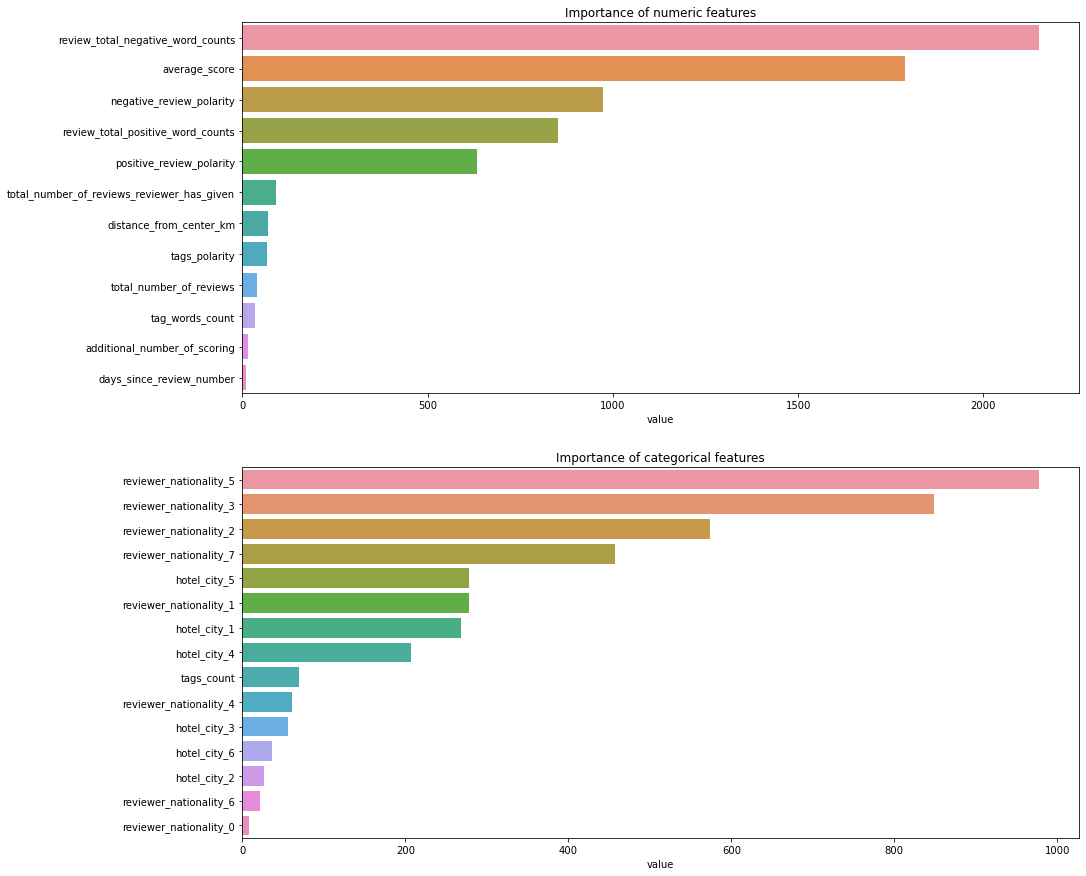

In [11]:
data = prepare_data(hotels)
train_and_estimate(data)

# 0.10171203647790096 (without fixing cells)
# 0.1017829206154738 (with fixed cells)
# 0.10196622100145573 (with)
# 0.10165175064321838 (all features considered)
# 0.12711422033654446
# 0.1007497879510659

# Predict and save submission

In [12]:
# test_data = prepare_data(hotels_test, is_test_data=True)
# test_pred = regr_model.predict(test_data)
# print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')


In [13]:
# submission[TARGET_COLUMN_NAME] = test_pred
# submission.to_csv('hotels_prediction.csv', index = False)